# **Numba**
Numba is a library which can speed up computations, especially loops, enormously. We look at two use cases: just-in-time compilation and parallelization.

## 1. **Just-In-Time (JIT) compilation**
JIT means that a function you write in Python is not evaluated in its Python code. Rather, it is translated into very fast machine code the first time you run it ('compilation' step). Function calls are accelerated after you run it for the first time. This works well for Python functions using only base-Python or numpy code, especially if they contain loops. However, not all functions are JITable. Numba will throw an error upon execution in such cases.

We JIT a function by including the decorator `@jit` in front of the function definition.

Whenever we can JIT a loop, the speed of execution will be comparable to high-speed, vectorized calculations.

In [1]:
from numba import jit
import numpy as np

**Example 1:** 
A function to sum the entries of a matrix.

In [2]:
def sum2d_slow(arr):
    M, N = arr.shape
    result = 0.0
    for i in range(M):
        for j in range(N):
            result += arr[i, j]
    return result

@jit(nopython=True)
def sum2d(arr):
    M, N = arr.shape
    result = 0.0
    for i in range(M):
        for j in range(N):
            result += arr[i, j]
    return result

arr = np.random.random((1000, 1000))
print(sum2d(arr))

499923.0173712615


In [3]:
%timeit sum2d(arr)
%timeit sum2d_slow(arr)

998 µs ± 243 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
160 ms ± 27.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**Example 2:** A function to calculate the nth entry of the Fibonacci sequence $x_n = x_{n-1} + x_{n-2}$ with $ x_{1}, x_2 = 1$.

In [4]:
@jit(nopython=True)
def fibonacci(n):
    if n <= 0:
        return 0
    elif n == 1:
        return 1
    else:
        return fibonacci(n-1) + fibonacci(n-2)

def fibonacci_slow(n):
    if n <= 0:
        return 0
    elif n == 1:
        return 1
    else:
        return fibonacci(n-1) + fibonacci(n-2)

# print(fibonacci(10))
%timeit fibonacci(15)
%timeit fibonacci_slow(15)

4.43 µs ± 229 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
4.77 µs ± 447 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


**Example 3:** A custom function to perform matrix multiplication.

In [5]:
@jit(nopython=True)
def matmul(A, B):
    M, K = A.shape
    K, N = B.shape
    C = np.empty((M, N))
    for i in range(M):
        for j in range(N):
            for k in range(K):
                C[i, j] += A[i, k] * B[k, j]
    return C

def matmul_slow(A, B):
    M, K = A.shape
    K, N = B.shape
    C = np.empty((M, N))
    for i in range(M):
        for j in range(N):
            for k in range(K):
                C[i, j] += A[i, k] * B[k, j]
    return C

A = np.random.random((100, 100))
B = np.random.random((100, 100))
print(matmul(A, B))
%timeit matmul(A, B)
%timeit matmul_slow(A, B)


[[2.32852718e+001 2.50722729e+001             nan ... 2.39382299e+001
  2.56571927e+001 2.40730599e+001]
 [2.71978880e+001 2.91807289e+001 2.61404410e+001 ... 2.78529992e+001
  2.96994188e+001 2.77821091e+001]
 [2.77624303e+001 2.87248923e+001 2.49097335e+001 ... 2.60752925e+001
  2.81926921e+001 2.88892825e+001]
 ...
 [1.51707891e+256 2.60814688e+001 2.26017181e+001 ... 2.45741654e+001
  4.02404539e+262 2.37329946e+001]
 [2.37680706e+001 2.78400775e+001 2.26235754e+001 ... 2.45313069e+001
  2.55779806e+001 4.24515340e+175]
 [2.41975184e+001 2.58609388e+001 2.43735146e+001 ... 2.47663520e+001
              nan 2.45585445e+001]]
526 µs ± 34.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
564 ms ± 101 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Exercise:** Time the functions in all examples and compare the runtime to a non-JIT'ed version.

## 2. **Parallelization**
We can make use of out computers' ability to perform multiple calculations at the same time with `numba`, too. To parallelize loops, the following two simple steps are needed:

1. The decorator becomes `@jit(nopython=True, parallel=True)`
2. All loops to be parallelized are called with `prange` objects, instead of the familiar `range`.

Parallelization works best in scenarios where tasks can be divided into independent units of work that can be executed concurrently without dependencies. This includes operations on large datasets, such as matrix multiplications, image processing, and simulations like Monte Carlo methods or random walks. It is particularly effective when the workload can be evenly distributed across multiple processors, minimizing the need for synchronization and communication between tasks. By leveraging parallelization, significant performance improvements can be achieved, especially in computationally intensive applications.

Here is an example for a parallelized matrix-multiplication:

In [6]:
from numba import prange

@jit(nopython=True, parallel=True)
def parallel_matmul(A, B):
    M, K = A.shape
    K, N = B.shape
    C = np.zeros((M, N))
    for i in prange(M):
        for j in prange(N):
            for k in range(K):
                C[i, j] += A[i, k] * B[k, j]
    return C

A = np.random.random((100, 100))
B = np.random.random((100, 100))
print(parallel_matmul(A, B))

[[23.35069311 27.50017271 24.63185793 ... 28.50520564 25.14140502
  23.66409307]
 [22.97969365 25.05998338 24.19738124 ... 26.6378747  25.23234817
  22.78316906]
 [22.20636476 24.33216434 25.41881577 ... 26.95197077 24.55029298
  23.73654879]
 ...
 [23.27332326 23.98045007 24.99129346 ... 25.87659919 22.59863273
  21.36358313]
 [24.8474635  26.34194698 24.55581231 ... 28.17513546 28.6453351
  26.80147468]
 [23.28408863 23.07189955 22.85638214 ... 26.35519741 25.8911545
  23.70584316]]


In [7]:
%timeit matmul(A, B)
%timeit parallel_matmul(A, B)

479 µs ± 26.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
319 µs ± 28.7 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


**Exercise:** Parallel simulation of a brownian motion.
The formula for a Geometric Brownian Motion (GBM) is given by:

$$ dS_t = \mu S_t \, dt + \sigma S_t \, dW_t $$

where:
- $ S_t $ is the stock price at time $ t $
- $ \mu $ is the drift coefficient (expected return)
- $ \sigma $ is the volatility coefficient (standard deviation of returns)
- $ dW_t $ is a Wiener process or Brownian motion

In its discrete form, the GBM can be expressed as:

$$ S_{t+\Delta t} = S_t \exp \left( \left( \mu - \frac{\sigma^2}{2} \right) \Delta t + \sigma \sqrt{\Delta t} \, Z_t \right) $$

where:
- $ \Delta t $ is the time increment
- $ Z_t $ is a standard normal random variable

This formula is commonly used in financial mathematics to model stock prices and other financial instruments.

Write a parallelized function `GBM_sim` which generates returns `N` brownian motion simulations of duration `T` each, and takes in the needed parameters. Which loops are easily parallelized and which are not?

In [8]:
@jit(nopython=True, parallel=True)
def GBM_sim(S0, mu, sigma, deltaT, T, N):

    deltaT_sqrt = deltaT**0.5 # pre-compute this guy 
    increments_num = int(np.floor(T/deltaT) + 1) # need integer number of increments
    log_GBMs = np.empty((N,increments_num))

    for n in prange(N):  # can be parallelized because iterations are independent
        log_GBMs[n, 0] = np.log(S0)
        for i in range(1, increments_num):  # can't be parallelized because each iteration affects the next
            log_GBMs[n, i] = log_GBMs[n, i-1] + (mu - sigma**2 / 2) * deltaT + sigma * deltaT_sqrt * np.random.normal()

    GBMs = np.exp(log_GBMs)
    return GBMs


GBMs = GBM_sim(S0 = 1, mu = 0.08, sigma = 1, deltaT = 0.001, T = 1, N = 10)

In [9]:
print(GBMs)

GBMs.shape

[[1.         1.01593404 1.01575172 ... 1.6329113  1.61665534 1.61843379]
 [1.         0.99688678 1.00285802 ... 0.21368836 0.1980476  0.21373162]
 [1.         1.04233525 1.06199677 ... 0.37441142 0.34827003 0.35483248]
 ...
 [1.         0.96365632 0.97175851 ... 1.19972689 1.22063666 1.18666659]
 [1.         1.01540495 1.06310066 ... 0.55070434 0.56953097 0.53739   ]
 [1.         1.06984291 1.04539333 ... 2.54441125 2.56484027 2.43059219]]


(10, 1001)

Let's plot some of these Brownian motions.

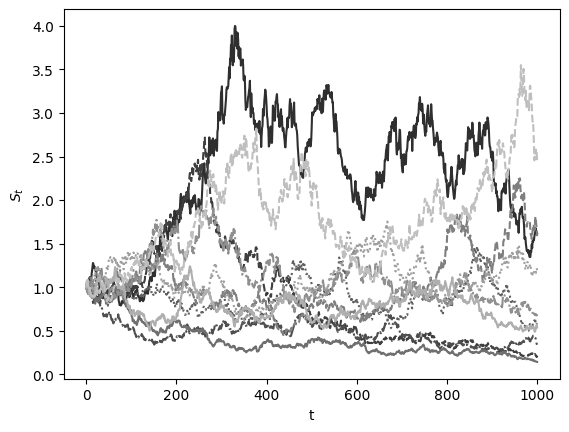

In [10]:
import matplotlib.pyplot as plt

# Define shades of dark grey and different linestyles
colors = ['#2f2f2f', '#3f3f3f', '#4f4f4f', '#5f5f5f', '#6f6f6f', '#7f7f7f', '#8f8f8f', '#9f9f9f', '#afafaf', '#bfbfbf']
linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--']

for i in range(GBMs.shape[0]):
    plt.plot(GBMs[i], color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)])

plt.ylabel(r'$S_t$')
plt.xlabel(r't')
plt.show()

Let's time the function:

In [11]:
%%timeit
GBM_sim(S0 = 1, mu = 0.08, sigma = 1, deltaT = 0.001, T = 1, N = 5000)

88.8 ms ± 18.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**Exercise:** Write a function ```call_payout(price, strike)```, which gives you the value of a call option at maturity if the price of the underlying are given in `prices` and you have the right (but not the obligation) to buy the underlying for the strike price `strike`.

In [12]:
def call_payout(prices, strike):
    payout = (prices - strike)
    payout[payout < 0] = 0
    return payout

print(call_payout(GBMs, 1.0))
print(call_payout(GBMs, 1.0).shape)

print(call_payout(GBMs, 1.0).mean(axis=0).shape)


[[0.         0.01593404 0.01575172 ... 0.6329113  0.61665534 0.61843379]
 [0.         0.         0.00285802 ... 0.         0.         0.        ]
 [0.         0.04233525 0.06199677 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.19972689 0.22063666 0.18666659]
 [0.         0.01540495 0.06310066 ... 0.         0.         0.        ]
 [0.         0.06984291 0.04539333 ... 1.54441125 1.56484027 1.43059219]]
(10, 1001)
(1001,)


**Exercise:** Write a function which simulates the mean expected payoffs of a call option on an asset initially priced at $S_0$ after $T$ periods. Simulate the function for `100_000` paths per GBM run, and across $\sigma \in \{0.5, 1, 2\}$

In [13]:
def sim_payoff(S0 = 1, mu = 0.08, sigma = 1, deltaT = 0.001, T = 1, N = 10000, discount_rate=0.03):
    GBMs = GBM_sim(S0, mu, sigma, deltaT, T, N)
    # print(GBMs)
    mean_payoff = call_payout(GBMs, 1.0).mean(axis=0)
    # print(call_payout(GBMs, 1.0))
    mean_payoff = mean_payoff / (1+discount_rate*deltaT) ** np.arange(T/deltaT+1)
    return mean_payoff

# mean_payoff = sim_payoff(S0 = 1, mu = 0.08, sigma = 0.5, deltaT = 0.001, T = 1, N = 100_000, discount_rate=0.08)
mean_payoff = sim_payoff(S0 = 1, mu = 0.08, sigma = 0.5, deltaT = 0.001, T = 1, N = 5, discount_rate=0.08)
print(mean_payoff.shape)

mean_payoff = mean_payoff[:,np.newaxis]
print(mean_payoff.shape)
sigmas = [1., 2., 3., 10.]
sigmas = list(np.linspace(1, 5, 5))

for i, sigma in enumerate(sigmas):
    mean_payoff = np.append(mean_payoff, sim_payoff(S0 = 1, mu = 0.08, sigma = sigma, deltaT = 0.001, T = 1, N = 100_000, discount_rate=0.08)[:, np.newaxis], axis=1)

print(mean_payoff.shape)

(1001,)
(1001, 1)
(1001, 6)


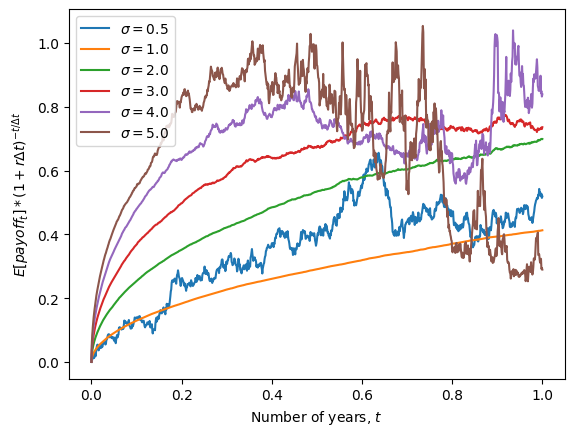

In [14]:
for i, sigma in enumerate([0.5] + sigmas):
    plt.plot(np.linspace(0, 1, len(mean_payoff[:, i])), mean_payoff[:, i] , label = f"$\sigma = {sigma}$")
plt.ylabel(r'$E[payoff_t] * (1+r \Delta t)^{-t/\Delta t}$')
plt.xlabel(r'Number of years, $t$')
plt.legend()
plt.show()